# Pre-Model Analysis for SABE Dataset

This notebook focuses on preparing the data for modeling, with an emphasis on analyzing factors that influence subjective memory evaluation and creating a coherence measure between subjective and objective memory measures.

In [142]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.decomposition import PCA


In [143]:
# Load the prepared dataset
df = pd.read_csv('transformed_csv/sabe_df_prepared.csv')
print(f"Dataset loaded successfully with {df.shape[0]} rows and {df.shape[1]} columns")


Dataset loaded successfully with 16601 rows and 98 columns


In [144]:
df['categoria_cognitiva'].value_counts()

1    14633
2     1948
3       20
Name: categoria_cognitiva, dtype: int64

## 1. Isolate Numerical Variables (Non-Binary)

In [145]:
# Function to identify binary variables
def is_binary(series):
    """Check if a column only contains 0/1 or True/False values"""
    # Drop NaN values for the check
    non_null = series.dropna()
    if non_null.empty:
        return False
    
    # Get unique values
    unique_vals = set(non_null.unique())
    
    # Check if it's a binary variable (0/1 or True/False)
    binary_sets = [{0, 1}, {False, True}]
    return any(unique_vals.issubset(binary_set) for binary_set in binary_sets) and len(unique_vals) <= 2

# Identify numeric, non-binary variables
numeric_cols = df.select_dtypes(include=['int64', 'Int64', 'float64']).columns.tolist()
binary_cols = [col for col in numeric_cols if is_binary(df[col])]
nonbinary_numeric = [col for col in numeric_cols if col not in binary_cols]

# Print the results
print(f"Total numeric columns: {len(numeric_cols)}")
print(f"Binary numeric columns: {len(binary_cols)}")
print(f"Non-binary numeric columns: {len(nonbinary_numeric)}")

# Display first 20 non-binary numeric variables
print("\nSample of non-binary numeric variables:")
print(nonbinary_numeric[:20])

Total numeric columns: 98
Binary numeric columns: 37
Non-binary numeric columns: 61

Sample of non-binary numeric variables:
['accesibilidad_vivienda', 'accesibilidad_hogar', 'seguridad_barrio', 'inseguridad_ambiental', 'percepcion_tradicional_vejez', 'percepcion_funcional_vejez', 'vejez_positiva', 'vejez_negativa', 'uso_medios_tradicionales', 'uso_medios_digitales', 'uso_redes_sociales_informales', 'participacion_fisica_salud', 'participacion_cultural_comunitaria', 'participacion_politica_gremial', 'recibe_ayuda', 'hace_trabajo_voluntario', 'nivel_apoyo_otros', 'dieta_balanceada', 'memoria_subjetiva', 'tiene_depresion']


#### Directionality of numeric variables

- -'accesibilidad_vivienda': high values mean high accesibilidad
- 'accesibilidad_hogar': high values mean high accesibilidad
- 'seguridad_barrio': high values mean high insecurity
- 'inseguridad_ambiental': high values mean high inseguridad_ambiental
- 'percepcion_tradicional_vejez': higher values mean a more traditional view of aging: based on age or appearance
- 'percepcion_funcional_vejez': higher values mean a more traditional view of aging: based on health, activity
- 'vejez_positiva': high values mean positive perception of aging
- 'vejez_negativa': high values mean more negative perception of aging
- 'uso_medios_tradicionales': higher values mean more reliance on traditional mass media (radio/tv)
- 'uso_medios_digitales': higher values mean more reliance on digital media(internet)
- 'uso_redes_sociales_informales': higher values mean more reliance on people to inform themselves
- 'participacion_fisica_salud': higher values mean more participation in physical activities
- 'participacion_cultural_comunitaria': higher values mean more participation in cultural, communitary work
- 'participacion_politica_gremial': higher values mean more participation in politics in the close social circle
- 'recibe_ayuda': high values mean the person receives more help from family, friends, government etc.
- 'hace_trabajo_voluntario': high values show person tends to do more voluntary work.
- 'nivel_apoyo_otros': high values mean the person has tended to be helpful with family, work, etc.
- 'dieta_balanceada': 0 not a balanced diet, 1: ideally balanced, 2: balanced
- 'memoria_subjetiva': high values show worst perception of own memory
- 'tiene_depresion': 3 (depressed)/2(mild depression)/1(no depression)


Statistics for minimental:
count    16601.000000
mean        16.608698
std          1.925950
min         13.000000
25%         15.000000
50%         17.000000
75%         18.000000
max         19.000000
Name: minimental, dtype: float64
Skewness: -0.33805952926547156
Kurtosis: -1.0758669080555174
Missing values: 0 (0.00%)

Statistics for memoria_subjetiva:
count    16601.000000
mean         8.082043
std          1.357715
min          3.000000
25%          7.000000
50%          8.000000
75%          9.000000
max         11.000000
Name: memoria_subjetiva, dtype: float64
Skewness: 0.6167628382048507
Kurtosis: -0.3030217790401668
Missing values: 0 (0.00%)


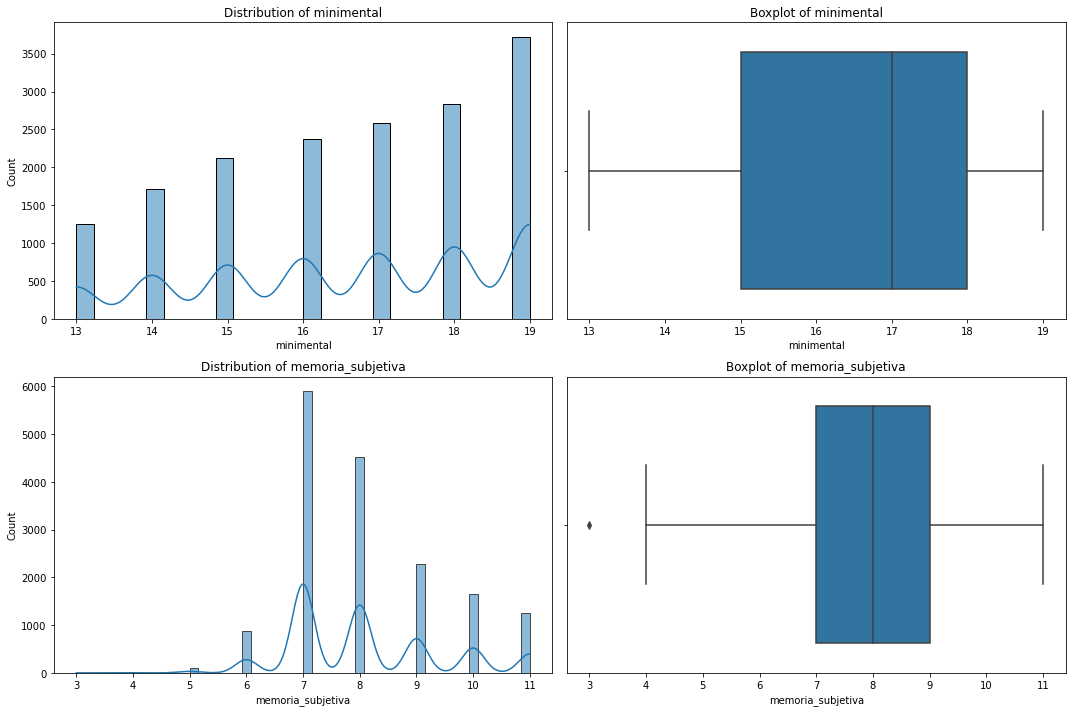

In [146]:
# Verify directionality and distribution of key variables
key_vars = ['minimental', 'memoria_subjetiva']
key_vars_present = [var for var in key_vars if var in df.columns]

if key_vars_present:
    # Create a figure to visualize distributions
    fig, axs = plt.subplots(len(key_vars_present), 2, figsize=(15, 5*len(key_vars_present)))
    
    # If only one variable present, adjust axes
    if len(key_vars_present) == 1:
        axs = axs.reshape(1, -1)
    
    # Plot histograms and boxplots for each key variable
    for i, var in enumerate(key_vars_present):
        # Histogram
        sns.histplot(df[var].dropna(), kde=True, ax=axs[i, 0])
        axs[i, 0].set_title(f'Distribution of {var}')
        axs[i, 0].set_xlabel(var)
        
        # Boxplot
        sns.boxplot(x=df[var].dropna(), ax=axs[i, 1])
        axs[i, 1].set_title(f'Boxplot of {var}')
        axs[i, 1].set_xlabel(var)
        
        # Print descriptive statistics
        print(f"\nStatistics for {var}:")
        print(df[var].describe())
        print(f"Skewness: {df[var].skew()}")
        print(f"Kurtosis: {df[var].kurtosis()}")
        print(f"Missing values: {df[var].isnull().sum()} ({df[var].isnull().mean():.2%})")
    
    plt.tight_layout()
    plt.show()
    
  

Summary statistics for non-binary numeric variables:


,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis,missing,missing_percent
accesibilidad_vivienda,16601.0,2.99,1.03,0.0,2.0,3.0,4.0,6.0,-0.31,-0.34,0,0.0
accesibilidad_hogar,16601.0,1.70,1.41,0.0,1.0,1.0,2.0,10.0,1.08,1.45,0,0.0
seguridad_barrio,16601.0,14.72,4.82,1.0,11.0,13.0,18.0,30.0,0.82,-0.07,0,0.0
inseguridad_ambiental,16601.0,1.99,0.91,0.0,1.0,2.0,3.0,7.0,0.35,-0.46,0,0.0
percepcion_tradicional_vejez,16601.0,0.74,0.78,0.0,0.0,1.0,1.0,2.0,0.50,-1.19,0,0.0
percepcion_funcional_vejez,16601.0,1.58,0.98,0.0,1.0,2.0,2.0,3.0,-0.02,-1.03,0,0.0
vejez_positiva,16601.0,1.61,0.86,0.0,1.0,2.0,2.0,3.0,0.16,-0.79,0,0.0
vejez_negativa,16601.0,0.81,1.00,0.0,0.0,0.0,1.0,3.0,0.95,-0.34,0,0.0
uso_medios_tradicionales,16601.0,2.59,1.26,0.0,2.0,2.0,4.0,4.0,-0.16,-1.29,0,0.0
uso_medios_digitales,16601.0,1.04,0.86,0.0,0.0,1.0,2.0,2.0,-0.09,-1.64,0,0.0


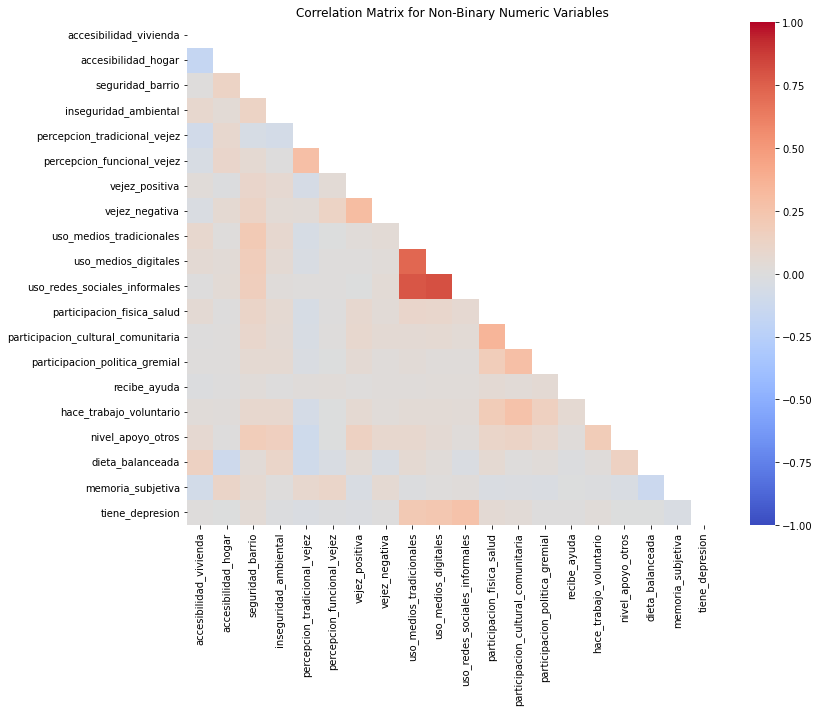

In [147]:
# Display summary statistics for all non-binary numeric variables
if nonbinary_numeric:
    # Create a smaller subset if there are too many variables
    display_vars = nonbinary_numeric[:20] if len(nonbinary_numeric) > 20 else nonbinary_numeric
    
    # Create a summary table
    summary = df[display_vars].describe().T
    
    # Add skewness and kurtosis
    summary['skewness'] = df[display_vars].skew()
    summary['kurtosis'] = df[display_vars].kurtosis()
    summary['missing'] = df[display_vars].isnull().sum()
    summary['missing_percent'] = df[display_vars].isnull().mean() * 100
    
    # Display the summary
    print("Summary statistics for non-binary numeric variables:")
    display(summary.round(2))
    
    # Create a correlation matrix and visualize it
    plt.figure(figsize=(12, 10))
    correlation_matrix = df[display_vars].corr()
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title('Correlation Matrix for Non-Binary Numeric Variables')
    plt.tight_layout()
    plt.show()

## 2. Create Coherence Variable (Minimental - Subjective Memory)

First, we need to determine whether to standardize or normalize the variables. We'll test both approaches and select the most appropriate one based on the data characteristics.

c:\Users\vaorc\anaconda3\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")



Shapiro-Wilk test for minimental:
Statistic: 0.9081, p-value: 0.0000
The minimental variable is not normally distributed (reject H0)

Shapiro-Wilk test for memoria_subjetiva:
Statistic: 0.8949, p-value: 0.0000
The memoria_subjetiva variable is not normally distributed (reject H0)

minimental skewness: -0.3381, kurtosis: -1.0759
The minimental variable has acceptable skewness and kurtosis for normal approximation

memoria_subjetiva skewness: 0.6168, kurtosis: -0.3030
The memoria_subjetiva variable has acceptable skewness and kurtosis for normal approximation


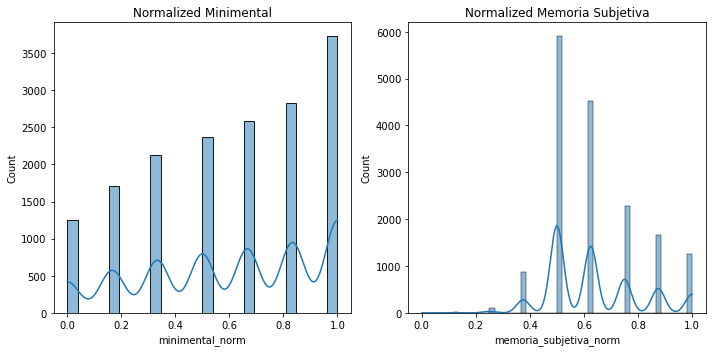

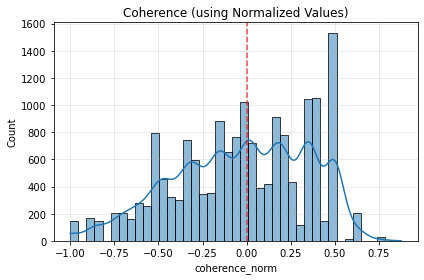


Using normalized values for coherence calculation due to non-normality

Description of the coherencia variable:
count    16601.000000
mean        -0.033806
std          0.375681
min         -1.000000
25%         -0.333333
50%          0.000000
75%          0.250000
max          0.875000
Name: coherencia, dtype: float64

Coherencia interpretation:
- Values close to 0: Good alignment between objective and subjective memory assessment
- Positive values: Objective cognitive function (Minimental) is better than subjective perception
- Negative values: Subjective perception of memory is better than objective performance


In [148]:

if 'minimental' in df.columns and 'memoria_subjetiva' in df.columns:
    # Get the data 
    mm_ms_df = df[['minimental', 'memoria_subjetiva']]

    # Test normality of the variables
    for var in ['minimental', 'memoria_subjetiva']:
        stat, p = stats.shapiro(mm_ms_df[var])
        print(f"\nShapiro-Wilk test for {var}:")
        print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")
        if p < 0.05:
            print(f"The {var} variable is not normally distributed (reject H0)")
        else:
            print(f"The {var} variable follows a normal distribution (fail to reject H0)")
    
    # Check skewness and kurtosis (normal if both between -2 and 2)
    for var in ['minimental', 'memoria_subjetiva']:
        skewness = mm_ms_df[var].skew()
        kurtosis = mm_ms_df[var].kurtosis()
        print(f"\n{var} skewness: {skewness:.4f}, kurtosis: {kurtosis:.4f}")
        if abs(skewness) < 2 and abs(kurtosis) < 2:
            print(f"The {var} variable has acceptable skewness and kurtosis for normal approximation")
        else:
            print(f"The {var} variable has high skewness or kurtosis, suggesting non-normality")
    
    
    # Normalization (Min-Max scaling to 0-1)
    normalizer = MinMaxScaler()
    normalized = pd.DataFrame(
        normalizer.fit_transform(mm_ms_df),
        columns=['minimental_norm', 'memoria_subjetiva_norm'],
        index=mm_ms_df.index
    )
    
    # Combine with original data
    transformed_df = pd.concat([mm_ms_df, normalized], axis=1)
    
    # Visualize the transformed variables
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Normalized
    sns.histplot(transformed_df['minimental_norm'], kde=True, ax=axs[0])
    axs[0].set_title('Normalized Minimental')
    sns.histplot(transformed_df['memoria_subjetiva_norm'], kde=True, ax=axs[1])
    axs[1].set_title('Normalized Memoria Subjetiva')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate coherence using both methods
    # Note: For memoria_subjetiva, higher values indicate worse subjective memory
    # To align the directions (higher = better for both), we use the negative of memoria_subjetiva
    
    # Using normalized values (with reversed memoria_subjetiva_norm)
    transformed_df['coherence_norm'] = transformed_df['minimental_norm'] - transformed_df['memoria_subjetiva_norm']
    
    # Visualize the coherence variables
    sns.histplot(transformed_df['coherence_norm'], kde=True)
    plt.title('Coherence (using Normalized Values)')
    plt.axvline(0, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    

    coherence_col = 'coherence_norm'
    print("\nUsing normalized values for coherence calculation due to non-normality")
    
    # Add the coherence variable to the main dataframe

    # Add normalized columns
    for idx, row in mm_ms_df.iterrows():
        df.loc[idx, 'minimental_norm'] = normalized.loc[idx, 'minimental_norm']
        df.loc[idx, 'memoria_subjetiva_norm'] = normalized.loc[idx, 'memoria_subjetiva_norm']
        df.loc[idx, 'coherencia'] = transformed_df.loc[idx, 'coherence_norm']
    
    # Describe the new coherence variable
    print("\nDescription of the coherencia variable:")
    print(df['coherencia'].describe())
    
    # Interpret coherence variable
    print("\nCoherencia interpretation:")
    print("- Values close to 0: Good alignment between objective and subjective memory assessment")
    print("- Positive values: Objective cognitive function (Minimental) is better than subjective perception")
    print("- Negative values: Subjective perception of memory is better than objective performance")
else:
    print("One or both required variables (minimental, memoria_subjetiva) are missing from the dataset.")

## 3. Correlation Analysis


Analyzing correlations for memoria_subjetiva

Top 15 variables correlated with memoria_subjetiva:
                            pearson  spearman
memoria_subjetiva_norm        1.000     1.000
coherencia                   -0.525    -0.487
sintomas_ultimo_mes           0.299     0.313
autopercepcion_salud         -0.267    -0.272
percepcion_visual            -0.241    -0.254
miedo_caer                    0.152     0.158
comido_menos                 -0.139    -0.141
nivel_educativo              -0.137    -0.129
impacto_salud_bucal          -0.127    -0.132
dieta_balanceada             -0.125    -0.126
a_educacion                  -0.122    -0.105
accesibilidad_hogar           0.113     0.113
percepcion_funcional_vejez    0.105     0.106
escala_barthel               -0.103    -0.129
talla                        -0.093    -0.095


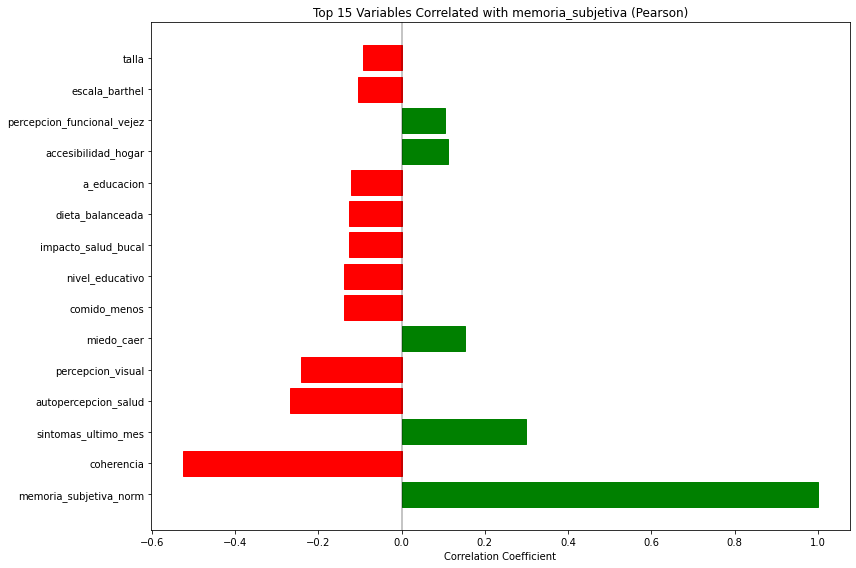




Analyzing correlations for categoria_cognitiva

Top 15 variables correlated with categoria_cognitiva:
                              pearson  spearman
minimental_norm                -0.524    -0.485
minimental                     -0.524    -0.485
coherencia                     -0.474    -0.444
nivel_educativo                -0.222    -0.291
a_educacion                    -0.218    -0.262
estrato                        -0.141    -0.146
percepcion_tradicional_vejez    0.120     0.121
color_piel                      0.110     0.107
edad                            0.108     0.100
peso                           -0.103    -0.105
nivel_apoyo_otros              -0.090    -0.090
accesibilidad_vivienda         -0.083    -0.085
comido_menos                   -0.082    -0.082
independencia_fuera            -0.080    -0.085
num_rooms_house                -0.076    -0.081


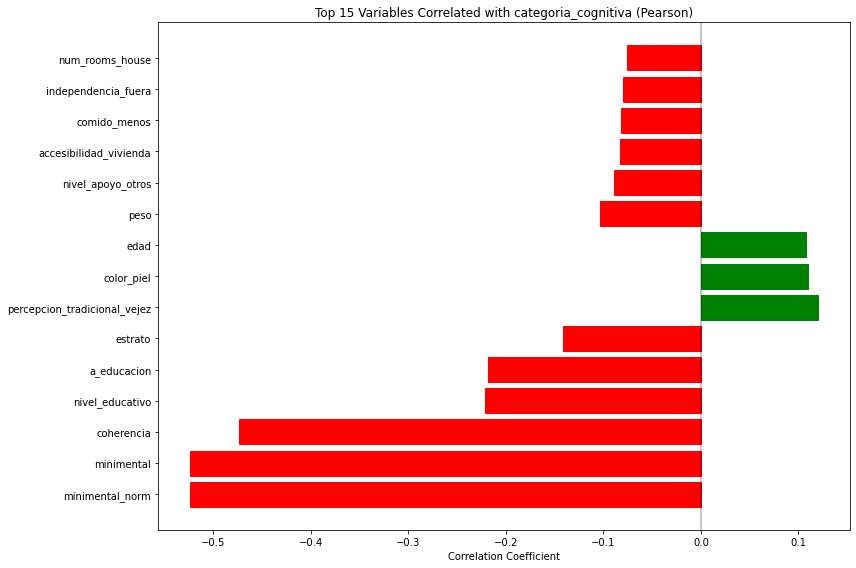




Analyzing correlations for minimental

Top 15 variables correlated with minimental:
                              pearson  spearman
minimental_norm                 1.000     1.000
coherencia                      0.893     0.899
categoria_cognitiva            -0.524    -0.485
nivel_educativo                 0.265     0.278
a_educacion                     0.234     0.222
edad                           -0.174    -0.166
percepcion_tradicional_vejez   -0.135    -0.137
estrato                         0.135     0.134
color_piel                     -0.114    -0.112
comido_menos                    0.111     0.107
independencia_fuera             0.104     0.114
peso                            0.099     0.099
accesibilidad_vivienda          0.095     0.099
escala_barthel                  0.088     0.104
memoria_subjetiva              -0.085    -0.086


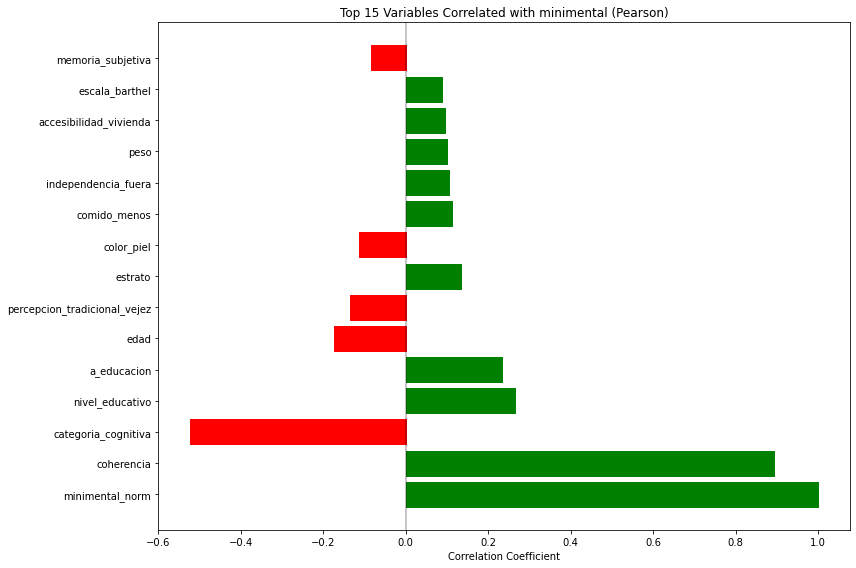




Analyzing correlations for coherencia

Top 15 variables correlated with coherencia:
                              pearson  spearman
minimental_norm                 0.893     0.899
minimental                      0.893     0.899
memoria_subjetiva_norm         -0.525    -0.487
memoria_subjetiva              -0.525    -0.487
categoria_cognitiva            -0.474    -0.444
nivel_educativo                 0.288     0.297
a_educacion                     0.255     0.237
sintomas_ultimo_mes            -0.206    -0.202
autopercepcion_salud            0.193     0.187
edad                           -0.186    -0.175
comido_menos                    0.158     0.151
percepcion_tradicional_vejez   -0.153    -0.155
percepcion_visual               0.148     0.145
estrato                         0.134     0.132
miedo_caer                     -0.126    -0.126


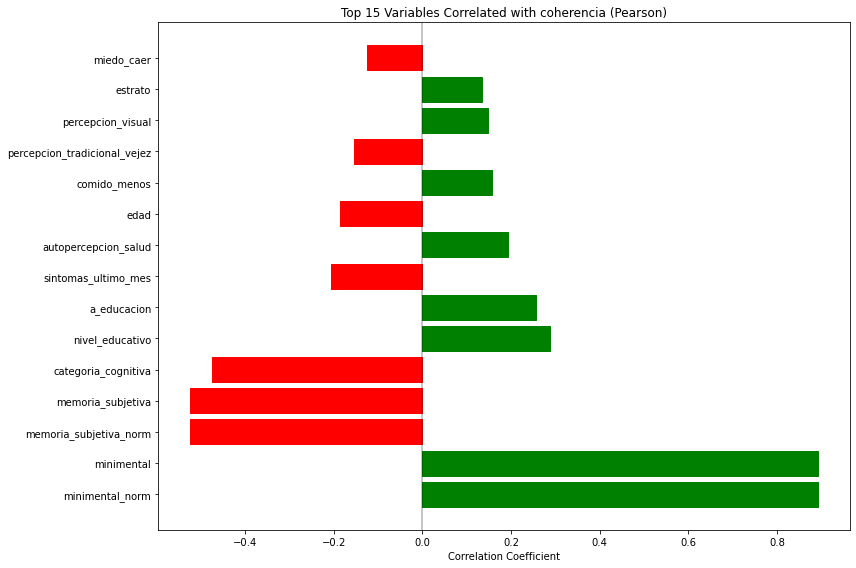

In [149]:
# Function to perform correlation analysis for a target variable
def analyze_correlations(df, target_var, top_n=15):
    """Analyze correlations between a target variable and all others."""
    # Calculate correlations with all numeric variables
    # Select numeric columns first
    numeric_cols = df.select_dtypes(include=['int64', 'Int64', 'float64']).columns
    # Filter out binary columns (those with only 2 unique values)
    numeric_cols = [col for col in numeric_cols if df[col].nunique()> 2]
    correlations = pd.DataFrame()
    
    # Pearson correlation
    pearson_corr = df[numeric_cols].corrwith(df[target_var], method='pearson')
    correlations['pearson'] = pearson_corr
    
    # Spearman correlation (rank-based, more robust to outliers)
    spearman_corr = df[numeric_cols].corrwith(df[target_var], method='spearman')
    correlations['spearman'] = spearman_corr
    
    # Drop the target variable itself
    correlations = correlations.drop(target_var, errors='ignore')
    
    # Sort by absolute Pearson correlation
    correlations['abs_pearson'] = correlations['pearson'].abs()
    correlations = correlations.sort_values('abs_pearson', ascending=False).drop('abs_pearson', axis=1)
    
    # Display top correlated variables
    print(f"\nTop {top_n} variables correlated with {target_var}:")
    print(correlations.head(top_n).round(3))
    
    # Visualize top correlations
    top_corr_vars = correlations.head(top_n).index.tolist()
    
    # Create a figure for visualization
    plt.figure(figsize=(12, 8))
    
    # Plot Pearson correlations
    bars = plt.barh(top_corr_vars, correlations.loc[top_corr_vars, 'pearson'])
    
    # Color the bars based on direction of correlation
    for i, bar in enumerate(bars):
        if correlations.loc[top_corr_vars[i], 'pearson'] > 0:
            bar.set_color('green')
        else:
            bar.set_color('red')
    
    plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
    plt.title(f'Top {top_n} Variables Correlated with {target_var} (Pearson)')
    plt.xlabel('Correlation Coefficient')
    plt.tight_layout()
    plt.show()
    
    return correlations

# Analyze correlations for the three target variables
target_variables = ['memoria_subjetiva', 'categoria_cognitiva', 'minimental', 'coherencia']

for target in target_variables:
    if target in df.columns:
        print(f"\n{'='*80}\nAnalyzing correlations for {target}\n{'='*80}")
        correlations = analyze_correlations(df, target)
        print("\n")
    else:
        print(f"Variable {target} not found in the dataset.")

In [150]:
for col in df.columns:
    print(col)

accesibilidad_vivienda
accesibilidad_hogar
seguridad_barrio
inseguridad_ambiental
percepcion_tradicional_vejez
percepcion_funcional_vejez
vejez_positiva
vejez_negativa
uso_medios_tradicionales
uso_medios_digitales
uso_redes_sociales_informales
no_esta_informado
participacion_religiosa
participacion_fisica_salud
participacion_cultural_comunitaria
participacion_politica_gremial
participacion_personas_mayores
no_participa_grupos
recibe_ayuda
hace_trabajo_voluntario
nivel_apoyo_otros
salida_forzada
salida_desastre
salida_economica
salida_servicios
salida_familiar
dieta_balanceada
memoria_subjetiva
tiene_depresion
estres_vida_temprana
autopercepcion_salud
sintomas_ultimo_mes
percepcion_visual
impacto_salud_bucal
discriminacion_color_piel
trato_injusto_edad
maltrato_familiar
maltrato_vejez
circ_cintura
independencia_fuera
velocidad_3metrosmins
area_vivienda
estrato
sexo
edad
estado_civil
num_personas_hogar
sabe_leer
sabe_escribir
a_educacion
nivel_educativo
studying
ha_trabajado
recibio_dine

In [151]:
# Save the enhanced dataframe with the coherencia variable
df.to_csv('transformed_csv/sabe_with_coherencia.csv', index=False)


In [152]:
df['categoria_cognitiva'].value_counts()

1    14633
2     1948
3       20
Name: categoria_cognitiva, dtype: int64

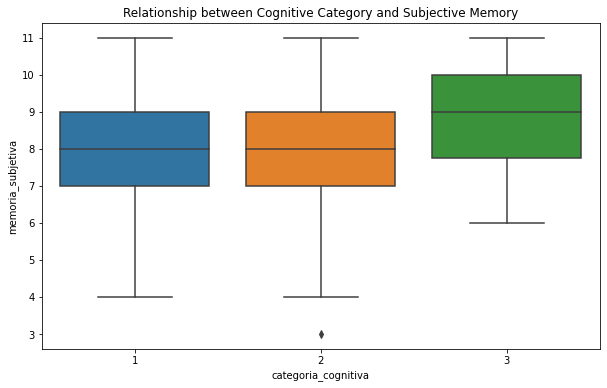

In [153]:
#'Normal':1, 'Mild impairment':2, 'Moderate impaired': 3 values for categoria cognitiva/memoria subjetiva (higher values represent worst perception)
plt.figure(figsize=(10, 6))
sns.boxplot(x='categoria_cognitiva', y='memoria_subjetiva', data=df)
plt.title('Relationship between Cognitive Category and Subjective Memory')
plt.show()

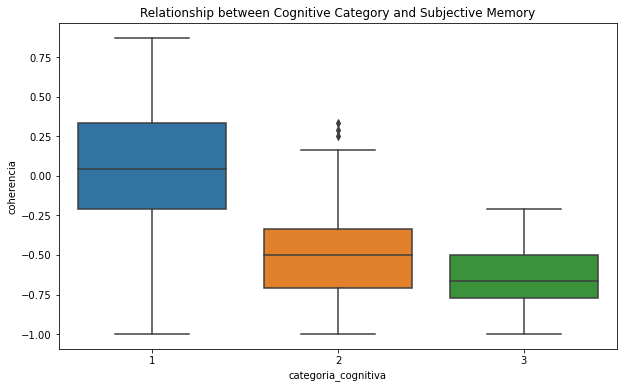

In [154]:
#'Normal':1, 'Mild impairment':2, 'Moderate impaired': 3 values for categoria cognitiva
plt.figure(figsize=(10, 6))
sns.boxplot(x='categoria_cognitiva', y='coherencia', data=df)
plt.title('Relationship between Cognitive Category and Subjective Memory')
plt.show()